In [1]:
print("""
@File         : Ch2.5-case-study-breast-cancer-diagnosis.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2025-08-25 22:25:47
@Email        : cuixuanstephen@gmail.com
@Description  : Ch2.5-case-study-breast-cancer-diagnosis
""")


@File         : Ch2.5-case-study-breast-cancer-diagnosis.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2025-08-25 22:25:47
@Email        : cuixuanstephen@gmail.com
@Description  : Ch2.5-case-study-breast-cancer-diagnosis



> We’ll train and evaluate bagging with decision trees, random forests, and Extra Trees to answer the following questions:
> -  How does the ensemble performance change with ensemble size? That is, what happens when our ensembles get bigger and bigger?
> - How does the ensemble performance change with base learner complexity? That is, what happens when our individual base estimators become more and more complex?

In [2]:
from sklearn.datasets import load_breast_cancer

datasets = load_breast_cancer()

import numpy as np
import pandas as pd

df = pd.DataFrame(data=datasets["data"], columns=datasets["feature_names"])
i = np.random.permutation(len(datasets['target']))
df = df.iloc[i, :7]
df['diagnosis'] = datasets['target'][i]
df = df.reset_index()
df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,diagnosis
0,162,19.59,18.15,130.70,1214.0,0.11200,0.16660,0.25080,0
1,343,19.68,21.68,129.90,1194.0,0.09797,0.13390,0.18630,0
2,227,15.00,15.51,97.45,684.5,0.08371,0.10960,0.06505,1
3,402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,1
4,157,16.84,19.46,108.40,880.2,0.07445,0.07223,0.05150,1


In [3]:
rng = np.random.RandomState(seed=4190)
X, y = datasets["data"], datasets["target"]

In [4]:
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
)

from sklearn.metrics import accuracy_score

if not os.path.exists("./data/ErrorVsNumEstimators.pickle"):
    max_leaf_nodes = 8
    n_runs = 20
    n_estimators_range = range(2, 20, 1)

    bag_trn_error = np.zeros((n_runs, len(n_estimators_range)))
    rf_trn_error = np.zeros((n_runs, len(n_estimators_range)))
    xt_trn_error = np.zeros((n_runs, len(n_estimators_range)))

    bag_tst_error = np.zeros((n_runs, len(n_estimators_range)))
    rf_tst_error = np.zeros((n_runs, len(n_estimators_range)))
    xt_tst_error = np.zeros((n_runs, len(n_estimators_range)))

    for run in range(0, n_runs):
        print("Run {0}".format(run))

        X_trn, X_tst, y_trn, y_tst = train_test_split(
            X, y, test_size=0.25, random_state=rng
        )

        for j, n_estimators in enumerate(n_estimators_range):
            bag_clf = BaggingClassifier(
                estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                n_estimators=n_estimators,
                max_samples=0.5,
                n_jobs=-1,
                random_state=rng,
            )
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            rf_clf = RandomForestClassifier(
                max_leaf_nodes=max_leaf_nodes,
                n_estimators=n_estimators,
                n_jobs=-1,
                random_state=rng,
            )
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            xt_clf = ExtraTreesClassifier(
                max_leaf_nodes=max_leaf_nodes,
                bootstrap=True,
                n_estimators=n_estimators,
                n_jobs=-1,
                random_state=rng,
            )
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))

    results = (
        bag_trn_error,
        bag_tst_error,
        rf_trn_error,
        rf_tst_error,
        xt_trn_error,
        xt_tst_error,
    )

    with open("./data/ErrorVsNumEstimators.pickle", "wb") as result_file:
        pickle.dump(results, result_file)
else:
    with open("./data/ErrorVsNumEstimators.pickle", "rb") as result_file:
        (
            bag_trn_error,
            bag_tst_error,
            rf_trn_error,
            rf_tst_error,
            xt_trn_error,
            xt_tst_error,
        ) = pickle.load(result_file)

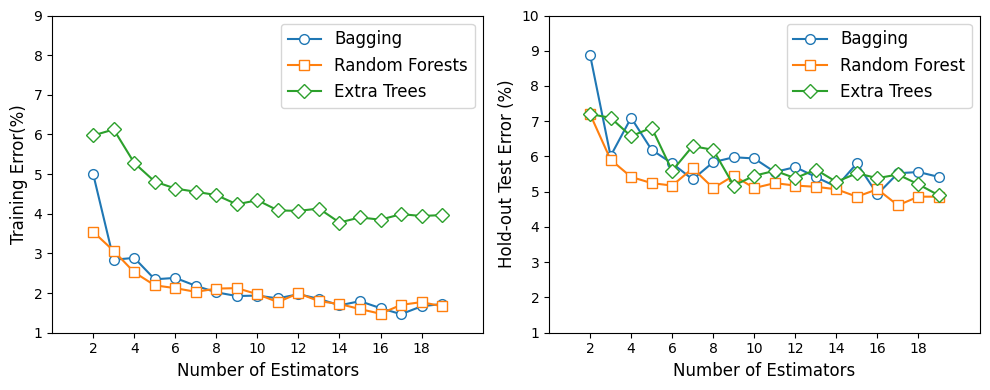

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_estimator_range = range(2, 20, 1)

m = np.mean(bag_trn_error * 100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker="o", markersize=7, mfc="w")
m = np.mean(rf_trn_error * 100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker="s", markersize=7, mfc="w")
m = np.mean(xt_trn_error * 100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker="D", markersize=7, mfc="w")

ax[0].legend(["Bagging", "Random Forests", "Extra Trees"], fontsize=12)
ax[0].set_xlabel("Number of Estimators", fontsize=12)
ax[0].set_ylabel("Training Error(%)", fontsize=12)
ax[0].set_xticks(range(2, 20, 2))
ax[0].axis([0, 21, 1, 9])

m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='o', markersize=7, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='s', markersize=7, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='D', markersize=7, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Number of Estimators', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)
# ax[1].grid()
ax[1].set_xticks(range(2, 20, 2))
ax[1].axis([0, 21, 1, 10]);
plt.tight_layout()

In [6]:
if not os.path.exists("./data/ErrorVsNumLeaves.pickle"):
    n_estimators = 10
    n_runs = 20
    n_leaf_range = [2, 4, 8, 16, 24, 32]

    bag_trn_error = np.zeros((n_runs, len(n_leaf_range)))
    rf_trn_error = np.zeros((n_runs, len(n_leaf_range)))
    xt_trn_error = np.zeros((n_runs, len(n_leaf_range)))

    bag_tst_error = np.zeros((n_runs, len(n_leaf_range)))
    rf_tst_error = np.zeros((n_runs, len(n_leaf_range)))
    xt_tst_error = np.zeros((n_runs, len(n_leaf_range)))

    for run in range(0, n_runs):
        print("Run {0}".format(run))

        X_trn, X_tst, y_trn, y_tst = train_test_split(
            X, y, test_size=0.25, random_state=rng
        )

        for j, max_leaf_nodes in enumerate(n_leaf_range):
            bag_clf = BaggingClassifier(
                estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                n_estimators=n_estimators,
                max_samples=0.5,
                n_jobs=-1,
                random_state=rng,
            )
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            rf_clf = RandomForestClassifier(
                max_leaf_nodes=max_leaf_nodes,
                n_estimators=n_estimators,
                n_jobs=-1,
                random_state=rng,
            )
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            xt_clf = ExtraTreesClassifier(
                max_leaf_nodes=max_leaf_nodes,
                bootstrap=True,
                n_estimators=n_estimators,
                n_jobs=-1,
                random_state=rng,
            )
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))

    results = (
        bag_trn_error,
        bag_tst_error,
        rf_trn_error,
        rf_tst_error,
        xt_trn_error,
        xt_tst_error,
    )

    with open("./data/ErrorVsNumLeaves.pickle", "wb") as result_file:
        pickle.dump(results, result_file)
else:
    with open("./data/ErrorVsNumLeaves.pickle", "rb") as result_file:
        (
            bag_trn_error,
            bag_tst_error,
            rf_trn_error,
            rf_tst_error,
            xt_trn_error,
            xt_tst_error,
        ) = pickle.load(result_file)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19


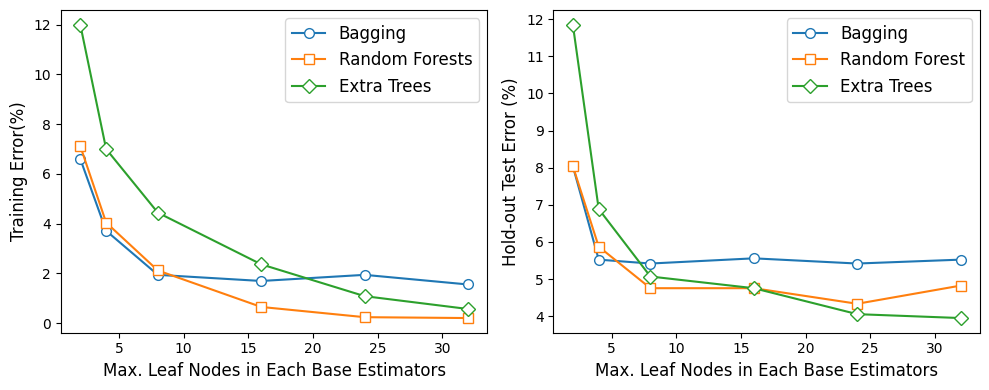

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_leaf_range = [2, 4, 8, 16, 24, 32]

m = np.mean(bag_trn_error * 100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker="o", markersize=7, mfc="w")
m = np.mean(rf_trn_error * 100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker="s", markersize=7, mfc="w")
m = np.mean(xt_trn_error * 100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker="D", markersize=7, mfc="w")

ax[0].legend(["Bagging", "Random Forests", "Extra Trees"], fontsize=12)
ax[0].set_xlabel("Max. Leaf Nodes in Each Base Estimators", fontsize=12)
ax[0].set_ylabel("Training Error(%)", fontsize=12)

m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='o', markersize=7, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='s', markersize=7, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='D', markersize=7, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Max. Leaf Nodes in Each Base Estimators', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)

plt.tight_layout()

### 2.5.3	Feature importances with Random Forests

<Axes: >

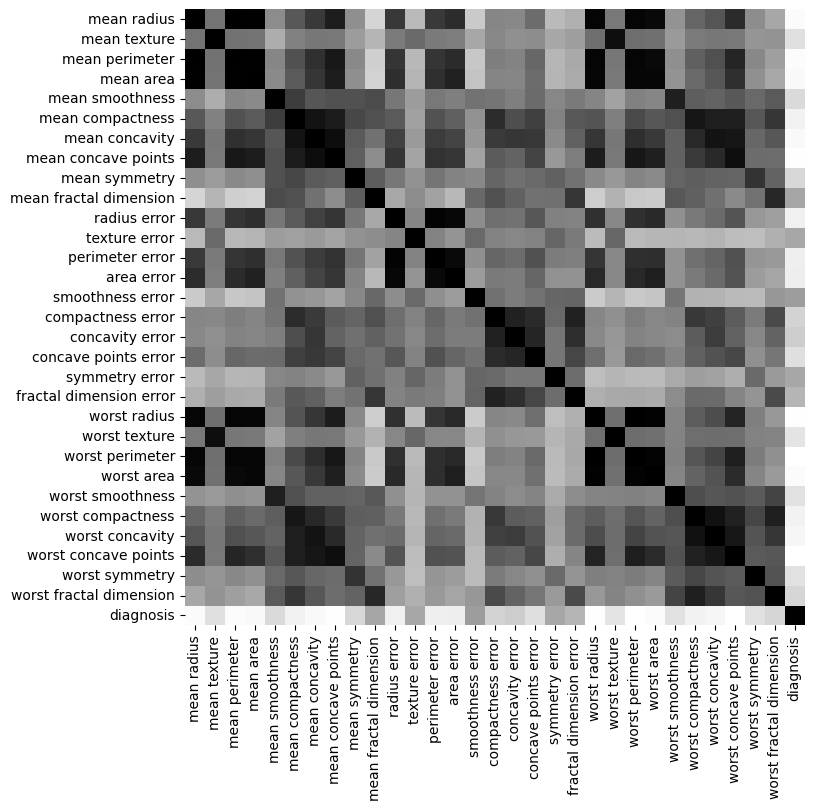

In [14]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=datasets['data'], columns=datasets['feature_names'])
df['diagnosis'] = datasets['target']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
cor = df.corr()
sns.heatmap(cor, annot=False, cbar=False, cmap=plt.cm.Greys, ax=ax)

In [17]:
label_corr = cor.abs().iloc[:, -1]
label_corr.sort_values(ascending=False)[1:11]

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: diagnosis, dtype: float64

#### Feature importances using random forests

In [24]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.15)
n_features = X_trn.shape[1]
rf = RandomForestClassifier(max_leaf_nodes=24, n_estimators=50, n_jobs=-1)
rf.fit(X_trn, y_trn)
err = 1 - accuracy_score(y_tst, rf.predict(X_tst))
print("Prediction Error = {0:4.2f}%".format(err * 100))

importance_threshold = 0.02
for i, (feature, importance) in enumerate(
    zip(datasets["feature_names"], rf.feature_importances_)
):
    if importance > importance_threshold:
        print("[{0}] {1} (score={2:4.3f})".format(i, feature, importance))

Prediction Error = 3.49%
[0] mean radius (score=0.045)
[2] mean perimeter (score=0.073)
[3] mean area (score=0.061)
[6] mean concavity (score=0.063)
[7] mean concave points (score=0.057)
[13] area error (score=0.028)
[20] worst radius (score=0.061)
[22] worst perimeter (score=0.127)
[23] worst area (score=0.137)
[24] worst smoothness (score=0.024)
[26] worst concavity (score=0.038)
[27] worst concave points (score=0.140)


[0] mean radius (score=0.045)
[2] mean perimeter (score=0.073)
[3] mean area (score=0.061)
[6] mean concavity (score=0.063)
[7] mean concave points (score=0.057)
[13] area error (score=0.028)
[20] worst radius (score=0.061)
[22] worst perimeter (score=0.127)
[23] worst area (score=0.137)
[24] worst smoothness (score=0.024)
[26] worst concavity (score=0.038)
[27] worst concave points (score=0.140)


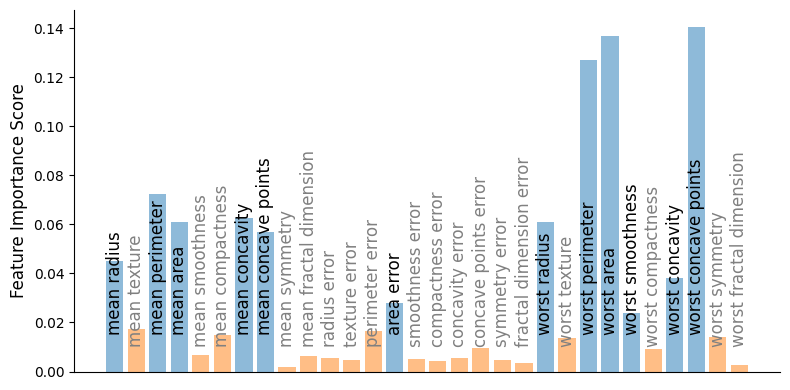

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
idx = np.array(range(n_features))
imp = np.where(rf.feature_importances_ > importance_threshold)
rest = np.setdiff1d(idx, imp) # set different

plt.bar(idx[imp], rf.feature_importances_[imp], alpha=.5)
plt.bar(idx[rest], rf.feature_importances_[rest], alpha=.5)
for i, (feature, importance) in enumerate(
    zip(datasets["feature_names"], rf.feature_importances_)
):
    if importance > importance_threshold:
        plt.text(
            i,
            0.015,
            feature,
            ha="center",
            va="bottom",
            rotation="vertical",
            fontsize=12,
        )
        print("[{0}] {1} (score={2:4.3f})".format(i, feature, importance))
    else:
        plt.text(
            i,
            0.01,
            feature,
            ha="center",
            va="bottom",
            rotation="vertical",
            fontsize=12,
            color='gray'
        )

fig.axes[0].get_xaxis().set_visible(False)
plt.ylabel("Feature Importance Score", fontsize=12)
plt.xlabel("Features for Breast Cancer Diagnosis", fontsize=12)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()

> CAUTION Note that feature importances will often change between runs owing to randomization during tree construction. Note also that if two features are highly correlated, random forests will often distribute the feature importance between them, leading to their overall weights appearing smaller than they actually are. There are other, more robust ways to compute feature importances for the purposes of ensemble interpretability.